# CLASSIFYING WINE DATASET

## General Imports and Settings

In [249]:
import numpy as np 
import scipy as sp 
from scipy import stats
from sklearn import datasets
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from seaborn import boxplot
import matplotlib.pyplot as plt

In [250]:
num_splits = 10
num_rep = 3
exec_time = datetime.today().strftime('%Y-%m-%d %H:%M:%S')

In [251]:
rskf = RepeatedStratifiedKFold(n_splits = num_splits, n_repeats = num_rep, random_state = 36851234)
skf = StratifiedKFold(n_splits=4)

### Leitura do dataset

In [252]:
wine_ds = datasets.load_wine()

wine_x = wine_ds.data
wine_y = wine_ds.target

## ZERO R

### Configuração do classificador

In [253]:
from sklearn.dummy import DummyClassifier

zr = DummyClassifier(strategy="prior")

processed_zr = Pipeline([('scaler', StandardScaler()), ('zr', zr)])

### Classificação e obtenção dos resultados

In [254]:
zr_scores = cross_val_score(processed_zr, wine_x, wine_y, scoring='accuracy', cv=rskf)
#print(score)

zr_score_mean = zr_scores.mean()
zr_score_std = zr_scores.std()
zr_score_low, zr_score_upp = stats.norm.interval(0.95, loc=zr_score_mean, scale=zr_score_std/np.sqrt(len(zr_scores)))

zr_results = ["ZR", zr_score_mean, zr_score_std, zr_score_low, zr_score_upp]

print("Zero R (mean, std, low, upp): \n", zr_score_mean, zr_score_std, zr_score_low, zr_score_upp)

Zero R (mean, std, low, upp): 
 0.3993464052287583 0.024707265583576204 0.3905051862508785 0.4081876242066381


## K NEAREST NEIGHBOR

### Configuração do classificador

In [255]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [256]:
grid_params = {'knn__n_neighbors': [1,3,5,7]}

processed_knn = Pipeline([('scaler', StandardScaler()), ('knn', knn)])

gs_knn = GridSearchCV(estimator=processed_knn, param_grid = grid_params, scoring='accuracy', cv = skf)

### Classificação e obtenção dos resultados

In [257]:
knn_scores = cross_val_score(gs_knn, wine_x, wine_y, scoring='accuracy', cv=rskf)
#print(score)

knn_score_mean = knn_scores.mean()
knn_score_std = knn_scores.std()
knn_score_low, knn_score_upp = stats.norm.interval(0.95, loc=knn_score_mean, scale=knn_score_std/np.sqrt(len(knn_scores)))

knn_results = ["KNN", knn_score_mean, knn_score_std, knn_score_low, knn_score_upp]
print("KNN (mean, std, low, upp): \n",knn_score_mean, knn_score_std, knn_score_low, knn_score_upp)

KNN (mean, std, low, upp): 
 0.9604575163398692 0.05318771771984477 0.9414248857274637 0.9794901469522747


## DECISION TREE

### Configuração do classificador

In [258]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

In [259]:
grade={'dt__max_depth': [3,5,10]}

processed_dt = Pipeline([('scaler', StandardScaler()), ('dt', dt)])
gs_dt = GridSearchCV(estimator=processed_dt, param_grid = grade, scoring='accuracy', cv = 4)

### Classificação e obtenção dos resultados

In [260]:
dt_scores = cross_val_score(gs_dt, wine_x, wine_y, scoring='accuracy', cv=rskf)
#print(score)

dt_score_mean = dt_scores.mean()
dt_score_std = dt_scores.std()
dt_score_low, dt_score_upp = stats.norm.interval(0.95, loc=dt_score_mean, scale=dt_score_std/np.sqrt(len(dt_scores)))

dt_results = ["DT", dt_score_mean, dt_score_std, dt_score_low, dt_score_upp]
print("dt (mean, std, low, upp): \n",dt_score_mean, dt_score_std, dt_score_low, dt_score_upp)

dt (mean, std, low, upp): 
 0.8896514161220043 0.07209164811607015 0.8638542251979662 0.9154486070460424


## NAIVE BAYES GAUSSIAN

### Configuração do classificador

In [261]:
from sklearn.naive_bayes import GaussianNB

nbg = GaussianNB()
processed_nbg = Pipeline([('scaler', StandardScaler()), ('nbg', nbg)])

### Classificação e obtenção dos resultados

In [262]:
nbg_scores = cross_val_score(processed_nbg, wine_x, wine_y, scoring='accuracy', cv=rskf)
#print(score)

nbg_score_mean = nbg_scores.mean()
nbg_score_std = nbg_scores.std()
nbg_score_low, nbg_score_upp = stats.norm.interval(0.95, loc=nbg_score_mean, scale=nbg_score_std/np.sqrt(len(nbg_scores)))


nbg_results = ["NBG", nbg_score_mean, nbg_score_std, nbg_score_low, nbg_score_upp]
print("nbg (mean, std, low, upp): \n",nbg_score_mean, nbg_score_std, nbg_score_low, nbg_score_upp)

nbg (mean, std, low, upp): 
 0.9734204793028323 0.0482047991331875 0.9561709304412 0.9906700281644645


## K Means Centroids

### Configuração do classificador

In [263]:
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from math import inf
from scipy.spatial.distance import euclidean

class KMeansCentroids(BaseEstimator):
    def __init__(self, num_centroids=1):
        super().__init__()
        self.num_centroids = num_centroids
        self.classes = {}
        self.centroids = {}

    def fit(self, x_train, y_train):
        kmeans = KMeans(n_clusters = self.num_centroids)
        
        self.classes = np.unique(y_train) # Extrai cada classe possivel
        self.classifing = {}
        for i in self.classes:
            group = x_train[y_train == i]
            kmeans.fit(group)
            atual_centroid = {i: kmeans.cluster_centers_}
            self.centroids.update(atual_centroid)

    def predict(self, x_train):
        pred = []
        #print(x_train[0])
        #print(self.centroids)
        
        for i in x_train:
            i_dist = inf

            for cluster_key in self.centroids:
                cluster_group = self.centroids[cluster_key]

                for cluster in cluster_group:
                    #print(i, cluster)
                    dist = euclidean(i, cluster)
                    #print(dist)
                    if dist < i_dist:
                        i_dist = dist
                        i_pred = cluster_key

            pred.append(i_pred)
        return pred

In [264]:
# kmc = KMeansCentroids(2)
# kmc.fit(wine_x, wine_y)
# kmc.predict(wine_x)

# cross_val_predict()

In [265]:
kmc = KMeansCentroids(2)
grid_params = {'kmc__num_centroids': [1,3,5,7]}
processed_kmc = Pipeline([('scaler', StandardScaler()), ('kmc', kmc)])
gs_kmc = GridSearchCV(estimator=processed_kmc, param_grid = grid_params, scoring='accuracy', cv = skf)


### Classificação e obtenção dos resultados

In [266]:
kmc_scores = cross_val_score(gs_kmc, wine_x, wine_y, scoring='accuracy', cv=rskf)
#print(score)

kmc_score_mean = kmc_scores.mean()
kmc_score_std = kmc_scores.std()
kmc_score_low, kmc_score_upp = stats.norm.interval(0.95, loc=kmc_score_mean, scale=kmc_score_std/np.sqrt(len(kmc_scores)))

kmc_results = ["KMC", kmc_score_mean, kmc_score_std, kmc_score_low, kmc_score_upp]
#print("kmc (mean, std, low, upp): \n",kmc_score_mean, kmc_score_std, kmc_score_low, kmc_score_upp)

## Results

### Imprime os Resultados

In [274]:
results = []

results.append(["Método", "Média", "Desvio Padrão", "Limite Inferior", "Limite Superior"])
results.append(zr_results)
results.append(knn_results)
results.append(kmc_results)
results.append(nbg_results)
results.append(dt_results)


for c in results:
    print(c[0], c[1])

#print(results)

Método Média
ZR 0.3993464052287583
KNN 0.9604575163398692
KMC 0.9660130718954247
NBG 0.9734204793028323
DT 0.8896514161220043


In [273]:
# Create file  results.md 
with open("../results/results.md", "w") as rf: #opening result file
    print("# Results Obtained", file=rf)
    print("## Configuration\n", file=rf)
    print("Num of folds: ", num_splits, "\n", file=rf)
    print("Num of repetitions: ", num_rep, "\n", file=rf)
    print("Test run on: ", exec_time, file=rf)
    
    print("## Zero R\n", file=rf)
    print("Mean Value: ", str(zr_score_mean), "\n", file=rf)
    print("Standart Variation: ", str(zr_score_std), "\n", file=rf)
    print("Lower limit: ", str(zr_score_low), "\n", file=rf)
    print("Upper limit: ", str(zr_score_upp), "\n", file=rf)

    print("## K NEAREST NEIGHBORS\n", file=rf)
    print("Mean Value: ", str(knn_score_mean), "\n", file=rf)
    print("Standart Variation: ", str(knn_score_std), "\n", file=rf)
    print("Lower limit: ", str(knn_score_low), "\n", file=rf)
    print("Upper limit: ", str(knn_score_upp), "\n", file=rf)

    print("## DECISION TREE\n", file=rf)
    print("Mean Value: ", str(dt_score_mean), "\n", file=rf)
    print("Standart Variation: ", str(dt_score_std), "\n", file=rf)
    print("Lower limit: ", str(dt_score_low), "\n", file=rf)
    print("Upper limit: ", str(dt_score_upp), "\n", file=rf)

    print("## NBG\n", file=rf)
    print("Mean Value: ", str(nbg_score_mean), "\n", file=rf)
    print("Standart Variation: ", str(nbg_score_std), "\n", file=rf)
    print("Lower limit: ", str(nbg_score_low), "\n", file=rf)
    print("Upper limit: ", str(nbg_score_upp), "\n", file=rf)

    print("## KMC\n", file=rf)
    print("Mean Value: ", str(kmc_score_mean), "\n", file=rf)
    print("Standart Variation: ", str(kmc_score_std), "\n", file=rf)
    print("Lower limit: ", str(kmc_score_low), "\n", file=rf)
    print("Upper limit: ", str(kmc_score_upp), "\n", file=rf)

In [268]:
with open("../results/scores.txt", "w") as rf: 
    print("Zero R\n", file=rf)
    print(str(zr_scores), "\n", file=rf)

    print("DECISION TREE\n", file=rf)
    print(str(dt_scores), "\n", file=rf)

    print("K NEAREST NEIGHBORS\n", file=rf)
    print(str(knn_scores), "\n", file=rf)

    print("NBG\n", file=rf)
    print(str(nbg_scores), "\n", file=rf)

    print("KMC\n", file=rf)
    print(str(kmc_scores), "\n", file=rf)


### Gera os graficos

### Tabela Wilcoxon e Test Rel

In [275]:
from scipy.stats import ttest_rel, wilcoxon

table_wil_rel = [[0 for x in range(5)] for y in range(5)]

table_wil_rel[0][0] = ('Zero R', zr_scores)
table_wil_rel[1][1] = ('Naive Bayes Gaussian', nbg_scores)
table_wil_rel[2][2] = ('K Means Centroids', kmc_scores)
table_wil_rel[3][3] = ('K Nearest Neighbor', knn_scores)
table_wil_rel[4][4] = ('Decision Tree', dt_scores)

for i in range(5):
    for j in range(5):
        if i != j:
            if i < j: #computar metrica ttest_rel no triangulo superior
                stat, pvalue = ttest_rel(table_wil_rel[i][i][1], table_wil_rel[j][j][1])
            if i > j: #computar metrica wilcoxon no triangulo inferior
                stat, pvalue = wilcoxon(table_wil_rel[i][i][1], table_wil_rel[j][j][1])
            table_wil_rel[i][j] = pvalue

table_wil_rel[0][0] = ('Zero R')
table_wil_rel[1][1] = ('Naive Bayes Gaussian')
table_wil_rel[2][2] = ('K Means Centroids')
table_wil_rel[3][3] = ('K Nearest Neighbor')
table_wil_rel[4][4] = ('Decision Tree')



for i in range(5):
    for j in range(5):
        if i == j:
            print(table_wil_rel[i][j], end=" ")
        else:
            print("%0.10f" % table_wil_rel[i][j], end=" ")
    print("\n")

Zero R 0.0000000000 0.0000000000 0.0000000000 0.0000000000 

0.0000008057 Naive Bayes Gaussian 0.2169484607 0.0527121786 0.0000000123 

0.0000011929 0.3307432884 K Means Centroids 0.3321132365 0.0000001931 

0.0000012490 0.1145886794 0.4536952997 K Nearest Neighbor 0.0000001536 

0.0000015302 0.0000182344 0.0000438727 0.0000206253 Decision Tree 



c:\Users\Pichau\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


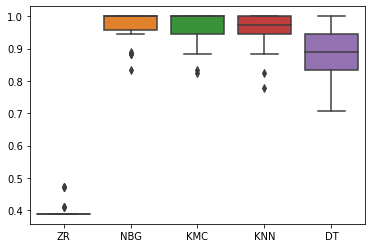

In [270]:
all_scores = {'ZR':zr_scores, 'NBG':nbg_scores, 'KMC':kmc_scores, 'KNN':knn_scores, 'DT':dt_scores}

graph = pd.DataFrame(all_scores)
boxplot(data=graph)

plt.show()